In [1]:
%matplotlib inline

In [2]:
from thetis import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.case_studies.tohoku.options.radial_options import TohokuRadialBasisOptions

In [5]:
from adapt_utils.unsteady.solver import AdaptiveProblem

We want to project into the Okada basis defined by varying slip and rake parameters.
However, if slip is everywhere zero then rake is also everywhere zero, meaning we cannot construct basis functions in the usual way.
Instead, we start by fixing rake at zero and solving only for slip.
Having solved for slip, we hold it fixed and solve for rake.

In [6]:
level = 1
kwargs = {
    'level': level,
    'okada_grid_lon_min': 140,
    'okada_grid_lon_max': 145,
    'okada_grid_lat_min': 35,
    'okada_grid_lat_max': 41,
}
op = TohokuOkadaBasisOptions(**kwargs)

## Get slip basis functions (with zero rake)

In [7]:
op.control_parameters['rake'] = np.zeros(190)

In [8]:
op.active_controls = ('slip', )

In [9]:
phi = [bf.split()[1] for bf in op.basis_functions['slip']]

INIT: Assembling Okada basis function array...


In [10]:
assert np.array([np.linalg.norm(phi_i.dat.data) for phi_i in phi]).min() > 0

## Define the target image

In [11]:
op_src = TohokuRadialBasisOptions(mesh=op.default_mesh, nx=1, ny=1, control_parameters=[6], level=level)
swp_src = AdaptiveProblem(op_src)
swp_src.set_initial_condition()
f_src = swp_src.fwd_solutions[0].split()[1]
del swp_src
del op_src

## Assemble RHS for slip solve

In [12]:
b = np.zeros(190)
for i in range(190):
    b[i] = assemble(f_src*phi[i]*dx)

## Solve for slip

In [13]:
swp = AdaptiveProblem(op)

In [14]:
N = 190
A = np.zeros((N, N))
for i in range(N):
    for j in range(i+1):
        A[i, j] = assemble(phi[i]*phi[j]*dx)
for i in range(N):
    for j in range(i+1, N):
        A[i, j] = A[j, i]

In [15]:
op.control_parameters['slip'] = np.linalg.solve(A, b)

In [16]:
surf = op.set_initial_condition(swp)

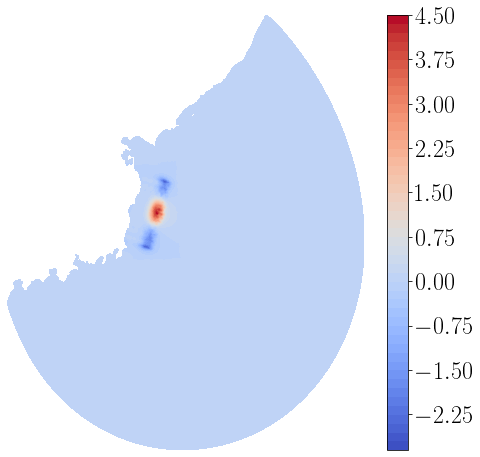

In [17]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(surf, cmap='coolwarm', levels=50, axes=axes), ax=axes)
axes.axis(False);

## Get rake basis functions

In [18]:
op.active_controls = ('rake', )

In [19]:
phi = [bf.split()[1] for bf in op.basis_functions['rake']]

INIT: Assembling Okada basis function array...


In [20]:
assert np.array([np.linalg.norm(phi_i.dat.data) for phi_i in phi]).min() > 0

## Assemble RHS for rake solve

In [21]:
b = np.zeros(190)
for i in range(190):
    b[i] = assemble(f_src*phi[i]*dx)

## Solve for rake

In [22]:
for i in range(N):
    for j in range(i+1):
        A[i, j] = assemble(phi[i]*phi[j]*dx)
for i in range(N):
    for j in range(i+1, N):
        A[i, j] = A[j, i]

In [23]:
op.control_parameters['rake'] = np.linalg.solve(A, b)

In [24]:
surf = op.set_initial_condition(swp)

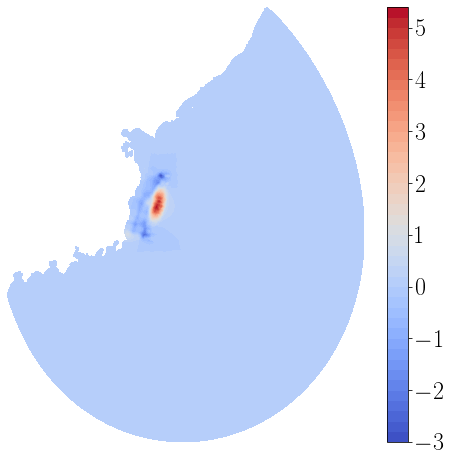

In [25]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(surf, cmap='coolwarm', levels=50, axes=axes), ax=axes)
axes.axis(False);